In [24]:
import os
os.chdir('/data/l989o/deployed/a')
import sys
if '/data/l989o/a' in sys.path:
    sys.path.remove('/data/l989o/a')
print(os.getcwd())
import numpy as np
print(np.random.randint(0, 5))
from jupy import *

/data/l989o/deployed/a
3


In [25]:
from data import RawCountDataset
import torch
import matplotlib.pyplot as plt
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          'text.color' : 'k',
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k"}
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update(params)

In [26]:
import os

os.makedirs('data/spatial_uzh_processed/a/', exist_ok=True)


def plt_show(plt, filename, dpi=72):
    f = os.path.join('data/spatial_uzh_processed/a', filename)
    print('saving figure in', f)
    plt.savefig(f, dpi=dpi, bbox_inches='tight')
    plt.show()


In [47]:
SPLIT = 'train'
# SPLIT = 'validation'
# SPLIT = 'test'

In [48]:
from data import AreaDataset
ds = AreaDataset(SPLIT)
ome_filenames = ds.filenames
list_of_cells = []
list_of_ome_filenames = []
list_of_ome_indices = []
list_of_cell_ids = []
for i, x in enumerate(ds):
    x = torch.tensor(x[1:])
    list_of_cells.append(x)
    list_of_ome_filenames.extend([ome_filenames[i]] * len(x))
    list_of_ome_indices.append(torch.tensor([i] * len(x)))
    list_of_cell_ids.append(torch.tensor(list(range(1, len(x) + 1))))
cells = torch.cat(list_of_cells)
ome_indices = torch.cat(list_of_ome_indices)
cell_ids = torch.cat(list_of_cell_ids)
print(f'cells.shape = {cells.shape}, ome_indices.shape = {ome_indices.shape}, cell_ids.shape = {cell_ids.shape}')

cells.shape = torch.Size([876951]), ome_indices.shape = torch.Size([876951]), cell_ids.shape = torch.Size([876951])


In [49]:
small_cells = cells[cells < 10]
from pprint import pprint
pprint(list(zip(*np.unique(small_cells, return_counts=True))))

[(1, 96809),
 (2, 4231),
 (3, 1471),
 (4, 1054),
 (5, 1042),
 (6, 1205),
 (7, 1296),
 (8, 1394),
 (9, 1510)]


saving figure in data/spatial_uzh_processed/a/cells_area_cutoff.png


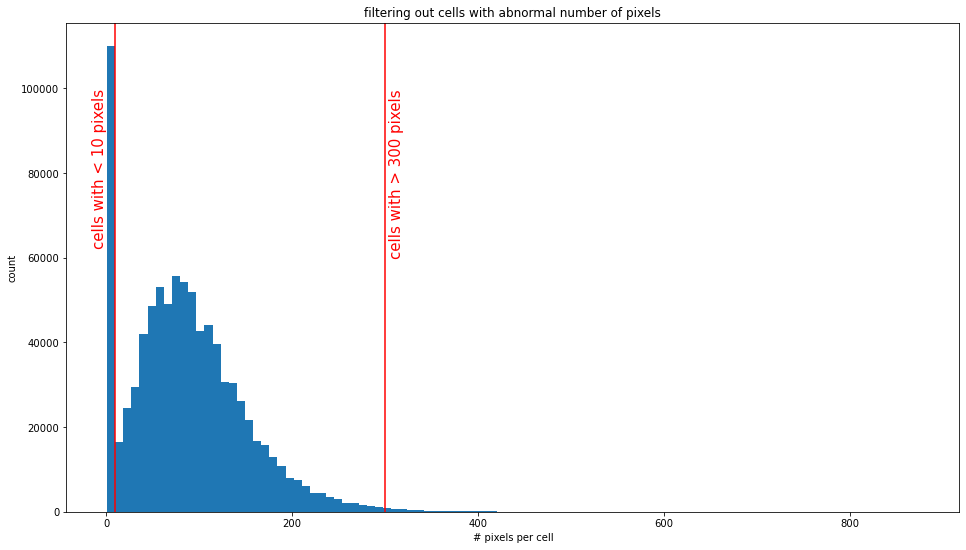

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.hist(cells.numpy(), bins=100)
a = 10
b = 300
plt.axvline(x=a, c='r')
plt.axvline(x=b, c='r')
plt.text(a - 25, 100000,f'cells with < {a} pixels',rotation=90, c='r', verticalalignment='top', fontsize=15)
plt.text(b + 4, 100000,f'cells with > {b} pixels',rotation=90, c='r', verticalalignment='top', fontsize=15)
plt.xlabel('# pixels per cell')
plt.ylabel('count')
plt.title('filtering out cells with abnormal number of pixels')
plt_show(plt, 'cells_area_cutoff.png')

saving figure in data/spatial_uzh_processed/a/cells_small_area.png


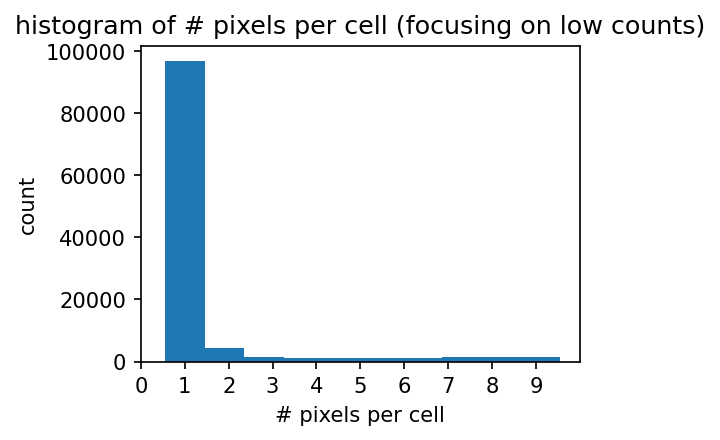

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=152)
plt.hist(cells.numpy()[cells <= a], bins=a, align='left')
plt.xlim([0, a])
plt.xticks(list(range(a)))
plt.xlabel('# pixels per cell')
plt.ylabel('count')
plt.title('histogram of # pixels per cell (focusing on low counts)')
plt.tight_layout()
plt_show(plt, 'cells_small_area.png', dpi=152)

saving figure in data/spatial_uzh_processed/a/cells_area_after_filtering.png


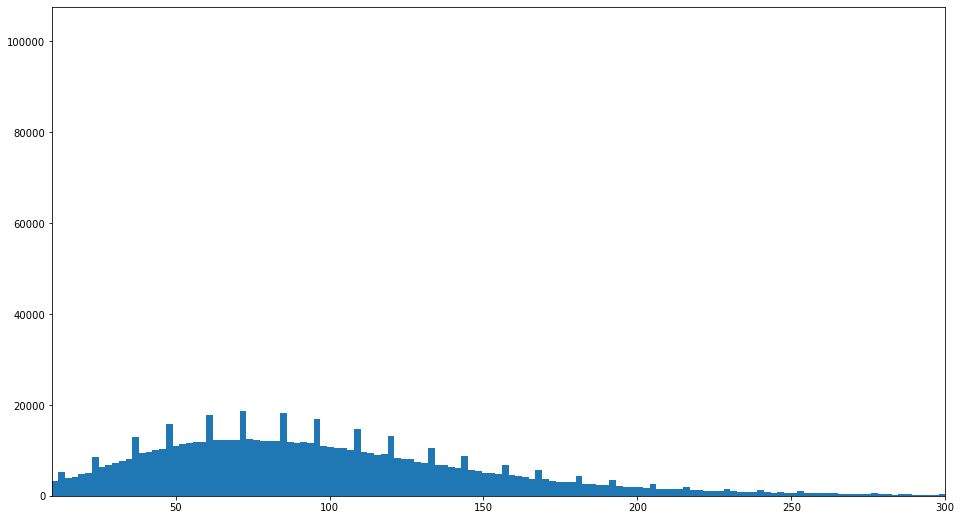

In [52]:
is_ok = (a <= cells) & (cells <= b)
import pickle
f = os.path.join('data/spatial_uzh_processed/a', f'ok_cells_{SPLIT}.npy')
is_ok.numpy()
d = {'list_of_cells': list_of_cells,
     'list_of_ome_indices': list_of_ome_indices,
     'list_of_ome_filenames': list_of_ome_filenames,
     'list_of_cell_ids': list_of_cell_ids,
     'cell_is_ok': is_ok.numpy()}
pickle.dump(d, open(f, 'wb'))
filtered_cells = cells[is_ok]

plt.figure(figsize=(16, 9))
plt.hist(cells.numpy(), bins=400)
plt.xlim([a, b])
plt_show(plt, 'cells_area_after_filtering.png')

In [33]:
large_cells = torch.nonzero(cells >= 700, as_tuple=True)[0]
print(large_cells)

tensor([ 61891, 186604, 281517, 440571, 502875, 503229])


saving figure in data/spatial_uzh_processed/a/big_cells.png


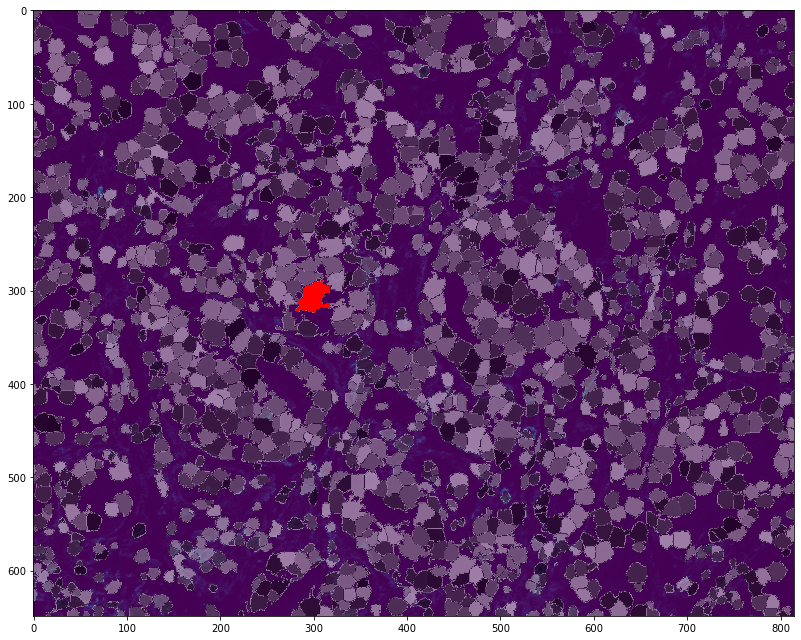

In [34]:
from data import OmeDataset, MasksDataset
import matplotlib
import colorsys
import random

ome_ds = OmeDataset(SPLIT)
masks_ds = MasksDataset(SPLIT)
for index in large_cells:
    ome_index = ome_indices[index]
    cell_id = cell_ids[index]
    ome = ome_ds[ome_index]
    masks = masks_ds[ome_index]
    masks_all = masks.copy()
    masks_all[masks > 0] = 1

    masks_big = masks.copy()
    masks_big[masks != cell_id.item()] = 0
    masks_big[masks == cell_id.item()] = 1

    channel = 20
    plt.figure(figsize=(16, 9))
    plt.imshow(ome[:, :, channel])


    n_grays = 10000
    g = np.random.random(n_grays)
    colors = [(g[i], g[i], g[i], 0.5) for i in range(n_grays)]
    colors[0] = (0., 0., 0., 0.)
    cmap_gray = matplotlib.colors.LinearSegmentedColormap.from_list('random gray', colors, N=n_grays)
    plt.imshow(masks, cmap_gray)

    cmap_list = [(0., 0., 0., 0.), (1., 0., 0., 1.)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('binary red', cmap_list, len(cmap_list))
    plt.imshow(masks_big, cmap=cmap)
    plt.tight_layout()
    plt_show(plt, 'big_cells.png')
    break